In [1]:
# processing
import math
from scipy import optimize
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_table('~/thomsonlab/simulation/percolation/run-series2/run0013/fiber_position.txt',
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])

In [4]:
df_short = df[df.length == 1.5]
df_long = df[df.length > 1.5]

x_long, y_long = df_long['posX'].tolist(), df_long['posY'].tolist()

In [5]:
# https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html

def calc_R(xc, yc):
    return np.sqrt((x_long-xc)**2 + (y_long-yc)**2)

def f_2(c):
    Ri = calc_R(*c)
    return Ri - Ri.mean()

In [6]:
center_2, ier = optimize.leastsq(f_2, (0, 0))

xc_2, yc_2 = center_2
R_2 = calc_R(*center_2).mean()

In [7]:
def find_circle(x, xc, yc, r):
    y_upper = yc + np.sqrt(r**2 - (x - xc)**2)
    y_lower = yc - np.sqrt(r**2 - (x - xc)**2)
    return y_upper, y_lower

In [8]:
def in_circle(row):
    x_coord = row['posX']
    if x_coord < (xc_2 - R_2) or x_coord > (xc_2 + R_2):
        return 0
    else:
        upper_bound, lower_bound = find_circle(x_coord, xc_2, yc_2, R_2)
        y_coord = row['posY']
        if y_coord > upper_bound or y_coord < lower_bound:
            return 0
        else:
            return 1

In [9]:
#df_short['in_circle'] = df_short.apply(lambda row: in_circle(row), axis=1)

fn = lambda row: in_circle(row)
col = df_short.apply(fn, axis=1)
df_short = df_short.assign(in_circle=col.values)

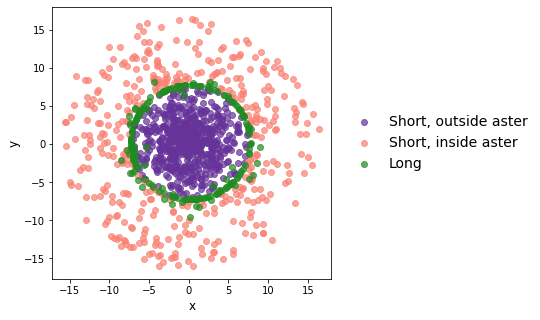

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df_short[df_short.in_circle == 1]['posX'],
            df_short[df_short.in_circle == 1]['posY'],
            alpha=0.7,
            color='rebeccapurple')
ax.scatter(df_short[df_short.in_circle == 0]['posX'],
            df_short[df_short.in_circle == 0]['posY'],
            alpha=0.7,
            color='salmon')
ax.scatter(df_long['posX'], df_long['posY'], alpha=0.7, color='forestgreen')
#ax.scatter(x, cu, color='red', s=5)
#ax.scatter(x, cl, color='red', s=5)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.legend(['Short, outside aster', 'Short, inside aster', 'Long'],
          bbox_to_anchor=(1.02, 0.65), fontsize=14, frameon=False)
plt.show()

In [11]:
def in_aster_fraction(fpath):
    df = pd.read_table(fpath,
                skiprows=5,
                delim_whitespace=True,
                names=['class', 'identity', 'length', 'posX', 'posY', 'dirX', 'dirY', 'endToEnd', 'cosinus', 'organizer'])
    
    df_short = df[df.length == 1.5]
    df_long = df[df.length > 1.5]
    x_long, y_long = df_long['posX'].tolist(), df_long['posY'].tolist()

    def calc_R(xc, yc):
        return np.sqrt((x_long-xc)**2 + (y_long-yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    center_2, ier = optimize.leastsq(f_2, (0, 0))
    xc_2, yc_2 = center_2
    R_2 = calc_R(*center_2).mean()

    fn = lambda row: in_circle(row)
    col = df_short.apply(fn, axis=1)
    df_short = df_short.assign(in_circle=col.values)

    expected_fraction = math.pi * R_2**2 / (math.pi * 16.92**2)

    return sum(df_short['in_circle']) / len(df_short), expected_fraction

In [12]:
aster_fraction = []
area_fraction = []
for i in range(6, 14):
    if i < 10:
        fpath = '~/thomsonlab/simulation/percolation/run-series2/run000{}/fiber_position.txt'.format(i)
    else:
        fpath = '~/thomsonlab/simulation/percolation/run-series2/run00{}/fiber_position.txt'.format(i)
    f_aster, f_area = in_aster_fraction(fpath)
    aster_fraction.append(f_aster)
    area_fraction.append(f_area)

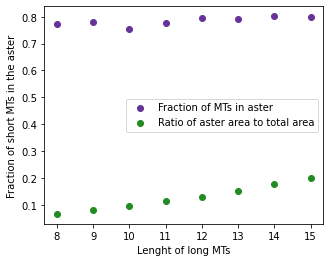

In [14]:
length = np.arange(8, 16, 1)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(length, aster_fraction, color='rebeccapurple')
ax.scatter(length, area_fraction, color='forestgreen')
ax.set_xlabel('Lenght of long MTs')
ax.set_ylabel('Fraction of short MTs in the aster')
ax.legend(['Fraction of MTs in aster', 'Ratio of aster area to total area'])
plt.savefig('./figures/percolation.png', dpi=300)
plt.show()